# Optic Disc Segmentation using Various Dataset and Various Methods

---

Imam Syahrizal, Izzun Nafis Ibadik, Pandega Abyan Zumarsyah

imamsyahrizal@mail.ugm.ac.id, izzunnafis2018@mail.ugm.ac.id, pandegaabyan@mail.ugm.ac.id

Departemen Teknik Elektro dan Teknologi Informasi Universitas Gadjah Mada

---

Program ini melakukan segmentasi optic disc pada citra fundus dengan menggunakan berbagai dataset dan berbagai metode

### Dataset
- **Dataset 1 ([source](https://drive.google.com/drive/u/1/folders/1Y2HpGf74_K5NYS0Fn4zMSMhOzLA7K0_l))**: Terdiri atas 100 citra fundus dengan resolusi 3072x2048 piksel. Kemudian terdapat ground truth berbentuk matriks berekstensi .mat yang mengandung informasi daerah optic disc dan optic cup
- **Dataset 2 (DRIONS-DB)**: Terdiri atas 110 citra fundus yang secara acak dipilih dari Ophthalmology Service di Miguel Servet Hospital, Saragossa (Spain). Citra disimpan dengan resolusi 600x400 piksel. Sebanyak 23% merupakan citra dari penderita glaukoma sementara 77% sisanya dari penderita hipertensi mata. Ground truth nya merupakan hasil anotasi oleh 2 ahli oftalmologi
- **Dataset 3 (RIM-ONE r3)**: Terdiri atas 159 citra fundus dari data milik Hospital Universitario de Canarias, Hospital Clínico San Carlos, dan Hospital Universitario Miguel Servet. Ketiganya merupakan rumah sakit Spanyol. Pada data ini, citra direpresentasikan sebagai citra stereo yang disusun horizontal. Anotasi dilakukan terhadap fitur optic disc sebelah kiri oleh dua ahli oftalmologi

### Metode
- **Metode 1**: Preprocessing => Blood Vessel Removal => Circular Hough Transform => GrowCut
- **Metode 2**: Empat metode yang saling berhubungan dengan memanfaatkan Thresholding, Grabcut, dan Fit-Ellipse
- **Metode 3**: Machine Learning dengan model Random Forest untuk Segmentasi
- **Metode 4**: Deep Learning berbasis Arsitektur UNet dengan Model MobileNetV2 lalu implementasinya menggunakan bantuan PyTorch

### Alur

Setiap metode dikembangkan utamanya untuk Dataset 1. Setelah itu berhasil untuk Dataset 1, barulah diuji untuk Dataset 2 dan 3. Namun, hasil untuk kedua dataset itu belum optimal, bahkan ada metode yang belum bisa memberikan hasil karena mengalami eror. 

Struktur dari program ini:
- Loading dataset dari Google Drive
- Pendefinisian berbagai fungsi umum
- Pendefinisian berbagai fungsi untuk setiap metode
- Running dengan menggunakan fungsi-fungsi yang sudah didefinisikan
- Perbandingan dari berbagai hasil yang sudah didapatkan

## Initialization
---
Ini meliputi mount Google Drive dan copy data dari Google Drive ke Colab

#### Mount Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Copy Data to Colab
---
Copy data dari Google Drive ke Colab agar pengolahannya bisa lebih cepat. 
Silakan uncomment data yang ingin digunakan. Alamatnya mungkin perlu penyesuaian.


In [ ]:
## Dataset 1
#!cp -r "/content/drive/Shareddrives/TPC Mini Project 2/Dataset/Topik 1 - Optic Disc Segmentation" "/content/"
## Dataset 2 DRIONS-DB
#!cp -r "/content/drive/Shareddrives/TPC Mini Project 2/Dataset/DRIONS-DB" "/content/"
## Dataset 3 RIM-ONE r3 combined
#!cp -r "/content/drive/Shareddrives/TPC Mini Project 2/Dataset/RIM-ONE r3 combined" "/content/"

## Functions for General
---
Ini meliputi import beberapa library dan fungsi-fungsi yang digunakan untuk semua metode. Fungsinya meliputi fungsi untuk load data, evaluasi, dan lainnya.

#### Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio
import os
import time
import cv2

pd.options.display.expand_frame_repr = False

### Load Data


#### Load Truths
---
Ketika menggunakan dataset yang diberikan, maka file nya berekstensi .mat sehingga loading nya membutuhkan fungsi khusus. Selain itu, diperlukan thresholding untuk mengambil bagian optic disc nya. Ketika menggunakan dua dataset lainnya, maka loading nya menggunakan cv2.imread()

Outputnya adalah dictionary dengan key nya adalah nama file tanpa ekstensi

In [ ]:
def load_mat(file_path):
    """
    Open MATLAB matrix file and return to numpy image matrix
    
    Parameters
    ---
    file_path : Matlab Ground truth file path

    Returns
    ---
    im_data.get('mask') : ground truth image matrix
    """
    im_data = sio.loadmat(file_path)
    return im_data.get('mask')

def load_truths(folder_path):
    """
    Load ground truth images from folder path
    Using cv2.imread(file, cv2.IMREAD_GRAYSCALE) to read image file
    
    Parameters
    ---
    folder_path : folder path of ground truth images

    Returns
    ---
    truths : dictionary of images with file name without extention as the key
    """
    if(folder_path == "/content/Topik 1 - Optic Disc Segmentation/Ground Truth"):     
      files = os.listdir(folder_path)
      truths = {}

      for file in files:
          img = load_mat(folder_path+'/'+file)
          _, truth = cv2.threshold(img, 0.5, 255, cv2.THRESH_BINARY)
          key = file.split('.')[0]
          truths[key] = truth
    else:
      files = os.listdir(folder_path)
      truths ={}

      for file in files:
          key = file.split('.')[0]
          truths[key] = cv2.imread(folder_path+'/'+file, cv2.IMREAD_GRAYSCALE)

    return truths

#### Load Images
---
Outputnya adalah dictionary dengan key nya adalah nama file tanpa ekstensi. Nama file nya sudah disesuaikan dengan ground truth sehingga key yang dihasilkan bisa serupa. Karena metode yang digunakan membutuhkan citra dan/atau V channel, maka outputnya ada dua: Citra dengan tipe RGB dan V channel dari citra tipe HSV. 

In [ ]:
def load_images(file_path):
    """
    Load images from folder path
    Using cv2.imread(file) to read image file

    Parameters
    ---
    folder_path : folder path of images

    Returns
    ---
    dictionary of images with file name without extention as the key
    images : dictionary contains image file in RGB color
    v_images : dictionary contains v channel of HSV color
    """
    files = os.listdir(file_path)
    images = {}
    v_images = {}

    for file in files:
        img0 = cv2.imread(file_path+'/'+file)
        img = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
        hsv_img = cv2.cvtColor(img0, cv2.COLOR_BGR2HSV)
        _,_,v_img = cv2.split(hsv_img)
        key = file.split('.')[0]
        images[key] = img
        v_images[key] = v_img

    return images, v_images

### Evaluation

#### Basic Parameter
---
Parameternya meliputi: True Positive, True Negative, False Positive, False Negative, Total True Pixel dari Ground Truth, dan Total True Pixel dari Segmented Image

In [ ]:
def count_true_pixel(input_img):
  """
  count the true pixel (assumed true pixel is white pixel)
  
  Parameters
  ---
  input_img : binary image

  Returns
  ---
  res_img : white pixel number
  """
  count_white = cv2.countNonZero(input_img)
  return count_white

def eval_basic_param(truth_img, segmented_binary_img):
  """
  Evaluate the basic parameters from ground truth image and segmented image
  
  Parameters
  ---
  truth_img : binary ground truth image
  segmented_binary_img : binary segmented image

  Returns
  ---
  TP : true positive
  TN : true negative
  FP : false positive
  FN : false negative
  T : true pixels of truth_img
  S : true pixels of segmented_binary_img 
  """
  truth_img = cv2.resize(truth_img, (segmented_binary_img.shape[1],segmented_binary_img.shape[0])) #in case you resize the original image
  truth_img = truth_img.astype('uint8')
  segmented_binary_img = segmented_binary_img.astype('uint8')

  TP = count_true_pixel(cv2.bitwise_and(segmented_binary_img, truth_img))
  TN = count_true_pixel(cv2.bitwise_not(cv2.bitwise_or(segmented_binary_img, truth_img)))
  FP = count_true_pixel(cv2.bitwise_and(segmented_binary_img, cv2.bitwise_not(truth_img)))
  FN = count_true_pixel(cv2.bitwise_and(cv2.bitwise_not(segmented_binary_img), truth_img))
  T = count_true_pixel(truth_img)
  S = count_true_pixel(segmented_binary_img)

  return TP, TN, FP, FN, T, S

#### Performance Evaluator
---
Outputnya adalah beberapa metrics: akurasi (ACC), spesifisitas (SP) , sensitivitas (SN), presisi atau Positive Predictive Value (PPV), False Discovery Rate (FDR), DICE, dan Overlap (OL)

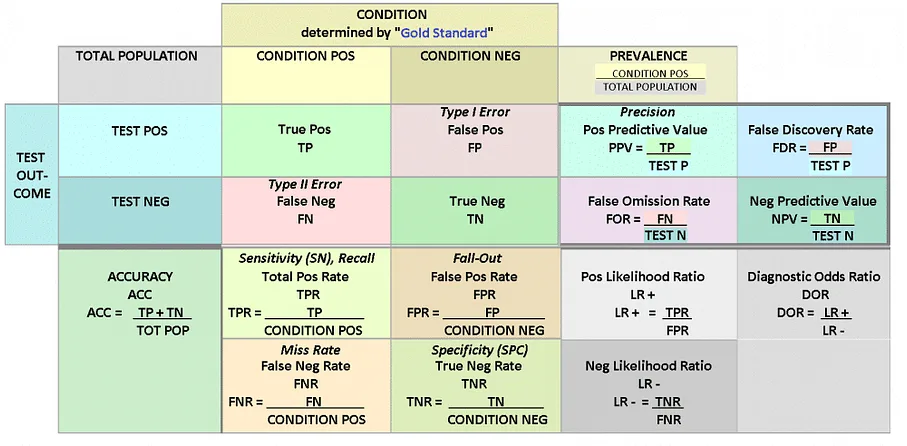

In [ ]:
def eval_perf(truth, image, param = ["ACC", "SP", "SN", "PPV", "FDR", "DICE", "OL"]):
  """
  Evaluate the performance of the segmentation
  Performance Metrics Code:
  ACC: accuracy
  SP: specificity
  SN: sensitivity
  PPV: positive predictive value
  FDR: false discovery rate
  DICE: dice coefficient
  OL: overlap
  
  Parameters
  ---
  truth :binary ground truth image
  segmented_binary_img : binary segmented image
  param : list of performance metrics code

  Returns
  ---
  res_dict :  dictionary of performance metrics based on param value
  """
  TP, TN, FP, FN, GT, P = eval_basic_param(truth, image)

  acc = (TP+TN)/(TP+TN+FP+FN)
  prec = TP/(TP+FP)
  sens = TP/(TP+FN)
  spec = TN/(FP+TN)
  FDR = FP/(TP+FP)
  DICE = 2*TP/(GT + P)
  overlap = TP/(TP+FP+FN)

  eval_dict = {"ACC":acc, "PPV":prec, "SN":sens, "SP":spec, "FDR":FDR, "DICE":DICE, "OL":overlap}

  res_dict = {}

  for i in param:
    res_dict[i] = eval_dict[i]
  return res_dict

### Finalization
---
Fungsi yang berguna pasca segmentasi. Ini meliputi fungsi untuk menyimpan skor dan menampilkan summary nya serta fungsi untuk menampilkan hasil segmentasi

#### Save scores and Get mean std
---
Scores yang awalnya berbentuk dictionary diubah menjadi DataFrame lalu diimpor sebagai file Excel. Selain itu, dihitung pula mean dan standar deviasi dari tiap performance metrics, lalu itu dijadikan DataFrame dan ditampilkan. 

In [ ]:
def save_scores_and_get_summary(scores, title, save=True, path="/content/drive/Shareddrives/TPC Mini Project 2/All Methods Result/"):
    """
    Take dictionary containing score then convert it to DataFrame and import it as Excel file
    It also calculates the mean and standard deviation of each performance metrics and print it
    
    Parameters
    ---
    scores : dictionary containing score
    title : title to be included in printing and excel file name
    save : if True, then the score will be imported as Excel file
    path : folder path to save the Excel file

    Returns
    ---
    summary :  summary of scores containing mean and standard deviation of each performance metrics
    """
    
    if(save):
        time_string = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
        df = pd.DataFrame(scores).transpose()
        df.to_excel(path + "Scores_" + title + "_" + time_string + ".xlsx")

    keys = scores.keys()
    
    acc = np.array([scores[i]['ACC'] for i in keys])
    prec = np.array([scores[i]['PPV'] for i in keys])
    sens = np.array([scores[i]['SN'] for i in keys])
    spec = np.array([scores[i]['SP'] for i in keys])
    FDR = np.array([scores[i]['FDR'] for i in keys])
    DICE = np.array([scores[i]['DICE'] for i in keys])
    overlap = np.array([scores[i]['OL'] for i in keys])

    summary = pd.DataFrame({
        'Accuracy': {'mean':acc.mean(), 'std':acc.std()},
        'Precision': {'mean':prec.mean(), 'std':prec.std()},
        'Sensitivity': {'mean':sens.mean(), 'std':sens.std()},
        'Specificity': {'mean':spec.mean(), 'std':spec.std()},
        'FDR': {'mean':FDR.mean(), 'std':FDR.std()},
        'DICE': {'mean':DICE.mean(), 'std':DICE.std()},
        'Overlap': {'mean':overlap.mean(), 'std':overlap.std()}
    })

    print('Scores of', title, 'for', len(keys), 'images:')
    print(summary)

    return summary

#### Plot Images
Menampilkan tiga citra yang bersesuaian: citra asli, ground truth dari citra itu, dan hasil segmentasi dari citra itu

In [ ]:
def plot_images(method_num, key, images, truths, segmented, path="/content/drive/Shareddrives/TPC Mini Project 2/All Methods Result/"):
    """
    Show three images in a row: original image, ground truth of that image, and segmentation result of that image
    
    Parameters
    ---
    method_num : method number that will be used in printing and image file name
    key : string key of the image
    images : dictionary contains original images
    truths : dictionary contains ground truth images
    segmented : dictionary contains segmented images
    path : folder path to save the plot

    Returns
    ---
    summary :  summary of scores containing mean and standard deviation of each performance metrics
    """
    figure, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(14, 6))

    ax0.imshow(images[key])
    ax0.set_title('Image '+key)
    ax0.axis('off')

    ax1.imshow(truths[key], cmap='gray')
    ax1.set_title('Ground Truth')
    ax1.axis('off')

    ax2.imshow(segmented[key], cmap='gray')
    ax2.set_title('Segmented using Method ' + str(method_num))
    ax2.axis('off')

    time_string = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
    figure.savefig(path + 'Method ' + str(method_num) + '/segmented ' + key + '_' + time_string + '.jpg')

## Functions for Method 1
---
Metode pertama yang kami gunakan ini berasal dari paper dengan judul Localization and Segmentation of Optic Disc in Retinal Images Using Circular Hough Transform and Grow-Cut Algorithm karya Muhammad Abdullah, et. al. Pada penelitian asli digunakan channel green dari sistem RGB. Di sini, kami mencoba menggunakan channel value dari sistem HSV. 

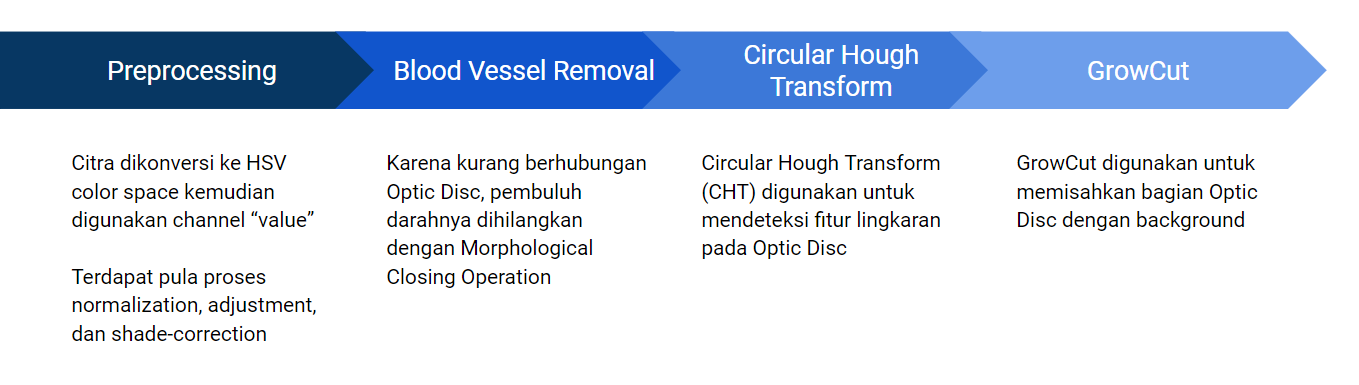

### Library

In [ ]:
import math
from skimage import img_as_float

### OD Detection
---
Ini meliputi tiga langkah pertama: Preprocessing yang menghasilkan shade-corrected image, Blood vessel removal, dan Circular Hough Transform untuk mendeteksi fitur lingkaran. Hasil akhirnya adalah koordinat pusat lingkaran yang valid untuk digunakan pada metode GrowCut. 

#### Shade Correction
---
Berbagai pengolahan pada citra awal untuk mendapatkan shade-corrected image. Dapat dioptimasi dengan menyesuaikan ukuran dan bentuk kernel. Untuk ukuran citra yang berbeda, maka ukuran kernelnya harus disesuaikan.

In [ ]:
def ShadeCorrection(img):
    """
    Various image processing to enhance the image before segmentation
    The output is a shade-corrected image
    
    Parameters
    ---
    img : numpy grayscale image

    Returns
    ---
    sc_img : numpy grayscale shade-corrected image
    """
    br_img = cv2.blur(img, (750, 750))

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (100, 100))
    open_img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

    norm_img = np.subtract(open_img.astype('int64'), br_img.astype('int64'))

    bin, data = np.histogram(img, bins=255)
    intVal_MaxPixels = data[np.argmax(bin)]
    adjusted_img = norm_img - intVal_MaxPixels + 127
    sc_img = adjusted_img.astype('uint8')

    return sc_img


#### Removing blood vessel
---
Penghilangan fitur pembuluh darah dari citra. Dapat dioptimasi dengan menyesuaikan ukuran dan bentuk kernel. Untuk ukuran citra yang berbeda, maka ukuran kernelnya harus disesuaikan.

In [ ]:
def RemoveBV(img, show=False):
    """
    Blood vessel removal of the fundus image using morphological closing
    
    Parameters
    ---
    img : numpy grayscale image
    show : if True, plot the resulted image

    Returns
    ---
    rbv_img : numpy grayscale removed blood vessel image
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (150,150))
    rbv_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    if(show):
        plt.imshow(rbv_img, cmap='gray')
        plt.title('rbv_img')
        plt.axis('off')
    return rbv_img

#### CHT circle
---
Pencarian fitur lingkaran pada citra fundus dengan Circular Hough Transform. Dapat dioptimasi dengan menyesuaikan parameter pada cv2.HoughCircles(). Untuk ukuran citra yang berbeda, maka parameter minRadius dan maxRadius harus disesuaikan.


In [ ]:
def CHTcircle(img, show=False):
    """
    Find circle features in the fundus image using Circular Hough Transform
    It is using cv2.HoughCircles() method
    
    Parameters
    ---
    img : numpy grayscale image
    show : if True, plot the resulted image

    Returns
    ---
    CHTc_img : numpy grayscale image with circles added
    circles : coordinates of the center of the circles
    """
    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,30,param1=10,param2=35,minRadius=180,maxRadius=220) # Optimize here
    CHTc_img = img.copy()
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        cv2.circle(CHTc_img,(i[0],i[1]),i[2],255,10)
    if(show):
        plt.imshow(CHTc_img, cmap='gray')
        plt.title('CHTc_img')
        plt.axis('off')
    return CHTc_img, circles

#### Approx valid CHT circle
---
Mencari lingkaran hasil CHT yang paling valid untuk memperkirakan pusat Optic Disc. Pendekatannya adalah dengan metode threshold kemudian mencari pusat massa dari hasil thresholding.


In [ ]:
def CHTvalid(img, circles):
    """
    Approximate valid circle from CHT result and the center of the Optic Disc.
    The approach using thresholding then find the center of mass from the thresholded image
    
    Parameters
    ---
    img : numpy grayscale image
    show : if True, plot the resulted image

    Returns
    ---
    valid_CHT : coordinate of the approximated center of the Optic Disc
    """
    _, thresholded_img = cv2.threshold(img, 240, 1, cv2.THRESH_BINARY) #here is the threshold method
    contours, hierarchy = cv2.findContours(thresholded_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    if(len(contours)>0):
        contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
        biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]

        M = cv2.moments(biggest_contour)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        CHTv = np.zeros(thresholded_img.shape, np.uint8)
        cv2.drawContours(CHTv, [biggest_contour], -1, 255, -1)

    else:
        cX = img.shape[1]/2
        cY = img.shape[0]/2


    min_dist = math.hypot(img.shape[0], img.shape[1])
    valid_CHT = [0, 0]

    for i in circles[0,:]:
        x_dist = i[0]-cX
        y_dist = i[1]-cY
        dist = math.hypot(x_dist, y_dist)
        if dist<min_dist:
            min_dist = dist
            valid_CHT = [i[0],i[1]]

    return valid_CHT

### Object Segmentation using GC
---
Konsep dari algoritma GrowCut adalah dengan menentukan initial state yang bisa dianggap pasti benar. Ini memerlukan prediksi dari proses CHT sebelumnya. Kemudian, dengan konsep attack/defense colony, state tersebut berkembang pada setiap iterasi. Iterasinya berhenti ketika tidak ada lagi perubahan. 

Perlu menjadi perhatian bahwa algoritma GrowCut ini cukup lambat sehingga agar lebih cepat perlu cropping dan penurunan resolusi.

#### Get Smaller Image
---
Terdapat cropping dan penurunan resolusi citra. Cropping dilakukan dengan koordinat hasil CHT sebagai pusatnya. Untuk citra dengan ukuran yang berbeda, parameternya perlu diatur kembali. 

In [ ]:
def cropNresize(img, center, crop_const=1000, scale=0.1, show=False):
    """
    Crop and resize to reduce the resolution of the image
    
    Parameters
    ---
    img : numpy grayscale image
    center : center of the cropping process
    crop_const : width of square used in cropping
    scale : scale when resizing the image
    show : if True, plot the resulted image

    Returns
    ---
    low_img : image with reduced resolution
    """
    crop_const = crop_const//2
    crop_img = img[center[1]-crop_const:center[1]+crop_const, center[0]-crop_const:center[0]+crop_const]

    dim = (int(crop_img.shape[0]*scale), int(crop_img.shape[1]*scale))
    low_img = cv2.resize(crop_img, dim, interpolation = cv2.INTER_AREA)

    if(show):
        plt.imshow(low_img, cmap='gray')
        plt.title('low_img')
    return low_img

#### Initialize State
---
Initial state dengan menentukan mana yang sudah pasti foreground dan mana yang sudah pasti background. Untuk citra dengan ukuran yang berbeda, parameternya perlu diatur kembali. Outputnya adalah citra dengan dua channel: initial state dan initial strength. 

In [ ]:
def createState(dim, inner_rad=5, outer_rad=50):
    """
    Create initial state contains assumption of the true foreground and the true background
    
    Parameters
    ---
    dim : dimension or resolution of the state image
    inner_rad : radius of the circle containing the true foreground
    outer_rad : radius of the circle that the region outside is the true background

    Returns
    ---
    state : image with two channel contains initial state and initial strength
    """

    center = (dim[0]//2, dim[1]//2)

    state0 = np.zeros(dim)
    cv2.circle(state0,center,outer_rad,1,-1)

    state1 = np.ones(dim)
    cv2.circle(state1,center,outer_rad,0,-1)
    cv2.circle(state1,center,inner_rad,1,-1)

    state = np.dstack((state0, state1))
    return state

#### Main GC
---
Fungsi utama dari algoritma GrowCut

In [ ]:
def GrowCut(image, state, max_iter=200, window_size=5):
    """
    Grow-cut segmentation
    Parameters
    ----------
    image : (M, N) ndarray
        Input image.
    state : (M, N, 2) ndarray
        Initial state, which stores (foreground/background, strength) for
        each pixel position or automaton.  The strength represents the
        certainty of the state (e.g., 1 is a hard seed value that remains
        constant throughout segmentation).
    max_iter : int, optional
        The maximum number of automata iterations to allow.  The segmentation
        may complete earlier if the state no longer varies.
    window_size : int
        Size of the neighborhood window.
    Returns
    -------
    mask : ndarray
        Segmented image.  A value of zero indicates background, one foreground.
    """
    image = img_as_float(image)
    height, width = image.shape
    ws = (window_size - 1) // 2

    n = 0
    changes = 1
    state_next = state.copy()

    while changes > 0 and n < max_iter:
        changes = 0
        n += 1

        for j in range(width):
            for i in range(height):

                C_p = image[i, j]
                S_p = state[i, j]
            
                winning_colony = S_p[0]
                defense_strength = S_p[1]

                for jj in range(max(0, j - ws), min(j + ws + 1, width)):
                    for ii in range(max(0, i - ws), min(i + ws + 1, height)):
                        if (ii == i and jj == j): continue

                        C_q = image[ii, jj]
                        S_q = state[ii, jj]

                        gval = 1 - abs(C_q - C_p)
                        attack_strength = S_q[1] * gval

                        if (attack_strength > defense_strength):
                            defense_strength = attack_strength
                            winning_colony = S_q[0]
                            changes += 1

                state_next[i, j, 0] = winning_colony
                state_next[i, j, 1] = defense_strength

        state, state_next = state_next, state
        print((n, changes), sep='-', end=', ')
        
    return state_next[:, :, 0]

#### Get Larger Image
---
Terdapat peningkatan resolusi citra kemudian meletakannya ke suatu blank image sebagai kompensasi dari proses cropping sebelumnya. Untuk citra dengan ukuran yang berbeda, parameternya perlu diatur kembali. Outputnya adalah citra dengan resolusi yang sesuai dengan resolusi citra awal. 

In [ ]:
def resizeNdecrop(img, center, resize_shape=(1000,1000), final_shape=(2048, 3072), crop_const=500, show=False):
    """
    Resize to increase the resolution of the image
    Then put the image in a blank image as a compensation of the cropping
    
    Parameters
    ---
    img : numpy grayscale image
    center : center of the cropping process
    resize_shape : output resolution of the resized image
    final_shape : final output resolution
    crop_const : width of square used in cropping
    show : if True, plot the resulted image

    Returns
    ---
    out_img*255 : image with recovered resolution
    """
    outcrop_img = cv2.resize(img, resize_shape, interpolation = cv2.INTER_LINEAR)

    out_img = np.zeros(final_shape, np.uint8)
    out_img[center[1]-crop_const:center[1]+crop_const, center[0]-crop_const:center[0]+crop_const] = outcrop_img

    if(show):
        plt.imshow(out_img, cmap='gray')
        plt.title('out_img')
        plt.axis('off')
    return out_img*255

## Functions for Method 2
---
Metode 2 ini menggunakan Thresholding dengan teknik tertentu, metode Grabcut, dan metode Fit-Ellipse. Ada empat pengujian berbeda yang saling berkaitan.

GrabCut merupakan model segmentasi iteratif yang berdasarkan Graph Cut. Graph Cut sendiri melakukan segmentasi secara kombinatoris dengan optimasi. Seperti GrowCut, GrabCut membutuhkan inisialisasi (mana yang sudah pasti foreground dan mana yang sudah pasti background)

Kemudian, Fit-Ellipse digunakan untuk membuat hasil segmentasi yang masih seperti elips kasar menjadi elips sempurna. Itu karena ground-truth yang ada juga berbentuk elips sempurna. 


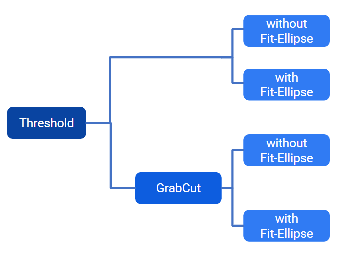

#### Fit ellipse
---
Fit-Ellipse digunakan untuk membuat hasil segmentasi yang masih seperti elips kasar menjadi elips sempurna. Itu karena ground-truth yang ada juga berbentuk elips sempurna. Fit-Ellips dilakukan dengan method cv2.fitEllipse()


In [ ]:
def ellipse_optimization(v_img, contour):
  """
  Optimization using cv2.fitEllipse(contour)

  Parameters
  ----------
  v_img : ndarray image
  contour : contour is stored as a vector of points

  Returns
  -------
  drawing : ndarray
      Segmented image that has been optimized using Fit-Ellipse
  """
  ell = cv2.fitEllipse(contour)
  drawing = np.zeros(v_img.shape, np.uint8)
  cv2.ellipse(drawing, ell, 255, -1)
  return drawing

#### Search Threshold
---
Mencari nilai threshold yang optimal dengan metode tertentu

In [ ]:
def search_thresh(img):
    """
    Search the optimum threshold value of an image

    Parameters
    ----------
    img : ndarray image

    Returns
    -------
    res : optimum threshold value
    """
    od_size_min_ratio = 1.74/(27*27)
    max_v = 255
    true = 0
    last_true = 0
    d_true = 0
    last_d_true = 0
    dd_true = 0
    already_peak = False
    thresh_val = 255
    res = 0
    
    for i in range (255):
      _, tmp_thresh_img = cv2.threshold(img, 255-i, 255, cv2.THRESH_BINARY)

      true = count_true_pixel(tmp_thresh_img)
      d_true = true-last_true
      dd_true = d_true-last_d_true
      last_true = true
      last_d_true = d_true

      if true > od_size_min_ratio:
        if dd_true<0 :
          already_peak = True
      
        if already_peak == True:
          if dd_true>0:
            res = 255-i
            break
    
    return res

#### Thresholding
---
Proses thresholding citra dengan metode tertentu berbasis nilai threshold optimum kemudian terdapat optimisasi dengan Fit-Ellipse

In [ ]:
def threshold_method(v_img):
  """
  Threshold the image using a method based on the optimum threshold value
  It also using Fit-Ellipse for further optimization

  Parameters
  ----------
  v_img : ndarray image

  Returns
  -------
  mask_2 : thresholded image without Fit-Ellipse optimization
  mask_ellipse : thresholded image with Fit-Ellipse optimization
  """
  threshold = search_thresh(v_img)
  _, tmp_thresh_img = cv2.threshold(v_img, threshold, 255, cv2.THRESH_BINARY)

  contours_2, hierarchy_2 = cv2.findContours(tmp_thresh_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

  if(len(contours_2)>0):
    contour_sizes_2 = [(cv2.contourArea(contour), contour) for contour in contours_2]
    biggest_contour_2 = max(contour_sizes_2, key=lambda x: x[0])[1]
  
    mask_2 = np.zeros(v_img.shape, np.uint8)
    cv2.drawContours(mask_2, [biggest_contour_2], -1, 255, -1)

  else :
    mask_2 = tmp_thresh_img

  mask_ellipse = ellipse_optimization(v_img, biggest_contour_2)

  return mask_2, mask_ellipse


#### Grabcut Optimization
---
Proses thresholding citra dengan metode tertentu berbasis nilai threshold optimum kemudian terdapat optimisasi dengan Grabcut lalu dengan Fit-Ellipse

In [ ]:
def grabcut_threshold_method(image, v_img):
  """
  Threshold the image using a method based on the optimum threshold value
  It also using Grabcut and Fit-Ellipse for further optimization

  Parameters
  ----------
  image : ndarray three channel image
  v_img : ndarray single channel image

  Returns
  -------
  mask_grabcut_out : thresholded image with Grabcut and without Fit-Ellipse optimization
  mask_grabcut_ellipse : thresholded image with Grabcut and Fit-Ellipse optimization
  """
#======================================================================================================
  threshold = search_thresh(v_img)
  _, tmp_thresh_img = cv2.threshold(v_img, threshold, 255, cv2.THRESH_BINARY) 

  contours_2, hierarchy_2 = cv2.findContours(tmp_thresh_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

  if(len(contours_2)>0):
    contour_sizes_2 = [(cv2.contourArea(contour), contour) for contour in contours_2]
    biggest_contour_2 = max(contour_sizes_2, key=lambda x: x[0])[1]
  
    mask_2 = np.zeros(v_img.shape, np.uint8)
    cv2.drawContours(mask_2, [biggest_contour_2], -1, 255, -1)

  else :
    mask_2 = tmp_thresh_img
#====================================================================================================== from threshold method

  size = (150, 150)
  shape = cv2.MORPH_ELLIPSE
  morph_th_kernel = cv2.getStructuringElement(shape, size)
  th_dilate = cv2.dilate(mask_2, morph_th_kernel)
  th_erode = cv2.erode(mask_2, morph_th_kernel)

  scale = 0.2
  dim = (int(v_img.shape[1]*scale), int(v_img.shape[0]*scale))
  low_img_gc = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  low_th_erode = cv2.resize(th_erode, (low_img_gc.shape[0:2][1],low_img_gc.shape[0:2][0]), interpolation = cv2.INTER_AREA)
  low_th_dilate = cv2.resize(th_dilate, (low_img_gc.shape[0:2][1],low_img_gc.shape[0:2][0]), interpolation = cv2.INTER_AREA)


  mask_gc_raw = np.zeros(low_img_gc.shape[0:2], np.uint8)
  bgdModel = np.zeros((1,65),np.float64)
  fgdModel = np.zeros((1,65),np.float64)

  mask_gc_raw[low_th_erode > 0] = cv2.GC_FGD
  mask_gc_raw[low_th_erode == 0] = cv2.GC_PR_BGD
  mask_gc_raw[low_th_dilate == 0] = cv2.GC_BGD
  mask_gc_raw, bgdModel, fgdModel = cv2.grabCut(low_img_gc,mask_gc_raw,None,bgdModel,fgdModel,10,cv2.GC_INIT_WITH_MASK)

  mask_grabcut = np.where((mask_gc_raw==cv2.GC_BGD)|(mask_gc_raw==cv2.GC_PR_BGD),0,255).astype('uint8')

  mask_grabcut_out = cv2.resize(mask_grabcut, (v_img.shape[1], v_img.shape[0]), interpolation = cv2.INTER_LINEAR)

  contours_grab, hierarchy_grab = cv2.findContours(mask_grabcut_out, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

  if(len(contours_grab)>0):
    contour_sizes_grab = [(cv2.contourArea(contour), contour) for contour in contours_grab]
    biggest_contour_grab = max(contour_sizes_grab, key=lambda x: x[0])[1]
  mask_grabcut_ellipse = ellipse_optimization(v_img, biggest_contour_grab)

  return mask_grabcut_out, mask_grabcut_ellipse

## Functions for Method 3
---
Random Forest Classifier digunakan untuk mengklasifikasikan setiap pixel menjadi beberapa kelas. Klasifikasi ini dilakukan dengan menggabungkan klasifikasi dari beberapa pohon (tree). Penggunaan tree yang banyak akan menambah akurasi. Model didapatkan dengan melakukan training pada sampel data yang dimiliki. 

Referensi utama terkait metode ini kami dapatkan dari [github](https://github.com/bnsreenu/python_for_microscopists)

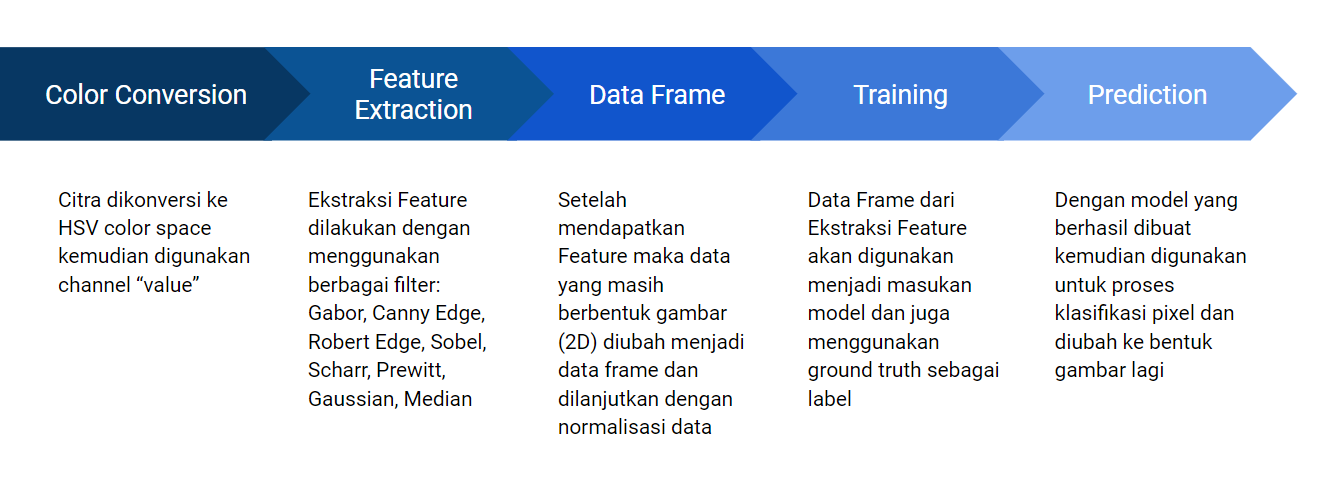

#### Library

In [ ]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy import ndimage as nd
from sklearn.model_selection import train_test_split
import pickle

#### Create Stack of Images
---
Ini diperlukan karena masukan untuk training model hanya bisa satu citra. Jika ingin banyak citra, maka citra-citra itu perlu distack

In [ ]:
def stack_images(keys, v_images, truths):
    """
    Stack Images using np.vstack()

    Parameters
    ----------
    keys : list contains keys of the image that will be stacked
    v_images : dictionary of images
    truths : dictionary of ground truths

    Returns
    -------
    IMG : stacked image
    GT : stacked ground truth
    """
    IMG = np.vstack([v_images[key] for key in keys])
    GT = np.vstack([truths[key] for key in keys])
    return IMG, GT

#### Feature Extraction
---
Mengekstrak berbagai fitur yang semuanya akan digunakan dalam Random Forest. Ini dilakukan karena Random Forest membutuhkan berbagai representasi dari citra yang sama. Yang digunakan di sini: Gabor Filter, Gaussian Filter, Median Filter, Canny, Robert, Sobel, Scharr, Prewitt

In [ ]:
def feature_extraction(img):
    """
    Extract many features of an image using multiple filters/processes:
    Gabor Filter, Gaussian Filter, Median Filter, Canny, Robert, Sobel, Scharr, Prewitt

    Parameters
    ----------
    img : ndarray image 

    Returns
    -------
    df_new : DataFrame contains multiple images from multiple filters/processes
    """

    img2 = img.reshape(-1)
    df = pd.DataFrame()
    df['Original Image'] = img2

    # Generate Feature from Filters
    # Gabor Filter
    num=1
    kernels = []
    for theta in range(1,2):
      theta = theta/4.*np.pi
      for sigma in (1,3):
        for lamda in np.arange(np.pi/4, np.pi, np.pi/4):
          gamma = 0.05
          gabor_label = 'Gabor ' + str(num) +'gamma ' + str(gamma) + '  lamda : ' + str(lamda) + '   sigma '+ str(sigma) + '   theta ' + str(theta)
          #print(gabor_label)
          num += 1
            
          ksize = 9
          kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma,  0, ktype=cv2.CV_32F)
          kernels.append(kernel)

          #filter image
          fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
          '''plt.imshow(fimg)
          plt.title(gabor_label)
          plt.show()'''
          #filtered_img = fimg.reshape(-1)
          fimg = fimg.reshape(-1)
          # save to data frame
          df[gabor_label] = fimg

    # CANNY EDGE
    edges = cv2.Canny(img, 100, 200)
    edges1 = edges.reshape(-1)
    df['Canny Edge'] = edges1
    #print('Canny')

    # ROBERT EDGE
    edge_roberts = roberts(img)
    edge_roberts1 = edge_roberts.reshape(-1)
    df['Roberts'] = edge_roberts1
    #print('Robert')

    # SOBEL
    edge_sobel = sobel(img)
    edge_sobel1 = edge_sobel.reshape(-1)
    df['Sobel'] = edge_sobel1
    #print('Sobel')

    # SCHARR
    edge_scharr = scharr(img)
    edge_scharr1 = edge_scharr.reshape(-1)
    df['Scharr'] = edge_scharr1
    #print('Scharr')

    #PREWITT
    edge_prewitt = prewitt(img)
    edge_prewitt1 = edge_prewitt.reshape(-1)
    df['Prewitt'] = edge_prewitt1
    #print('Prewit')

    #GAUSSIAN with sigma=3
    gaussian_img = nd.gaussian_filter(img, sigma=3)
    gaussian_img1 = gaussian_img.reshape(-1)
    df['Gaussian s3'] = gaussian_img1
    #print('Gaussian 1')

    #GAUSSIAN with sigma=7
    gaussian_img2 = nd.gaussian_filter(img, sigma=7)
    gaussian_img3 = gaussian_img2.reshape(-1)
    df['Gaussian s7'] = gaussian_img3
    #print('Gaussian 2')

    #MEDIAN with sigma=3
    median_img = nd.median_filter(img, size=3)
    median_img1 = median_img.reshape(-1)
    df['Median s3'] = median_img1
    #print('Median')

    # NORMALIZE data frame
    x = df.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_new = pd.DataFrame(x_scaled)

    return df_new

#### Image Segmentation
---
Segmentasi suatu citra dengan model Random Forest berdasarkan berbagai fitur dari citra tersebut

In [ ]:
def segment_image(v_img, model):
    """
    Image segmentation using Random Forest model based on multiple features

    Parameters
    ----------
    v_img : ndarray image
    model : Random Forest model

    Returns
    -------
    segmented : ndarray segmented image
    """
    X = feature_extraction(v_img)
    result = model.predict(X)
    # back to image size
    segmented = result.reshape(v_img.shape)

    return segmented

## Functions for Method 4
Metode 4 menggunakan Deep Learning dengan arsitektur UNet. UNet merupakan arsitektur CNN yang didesain untuk segmentasi citra medis. Model yang digunakan adalah MobileNetV2 yang telah dilatih menggunakan dataset ImageNet. MobileNetV2 menggunakan depthwise separable convolution (Dwise) sehingga bisa lebih ringan dan lebih efisien. Kemudian, implementasinya dilakukan dengan bantuan PyTorch. 

Referensi utama terkait metode ini kami dapatkan dari [kaggle](https://kaggle.com/ligtfeather/semantic-segmentation-is-easy-with-pytorch)

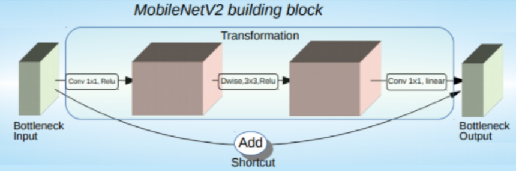

### Library

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torch.nn.functional as F

import pickle

import albumentations as A
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

!pip install -q segmentation-models-pytorch
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Jika terjadi error: *cannot import name 'container_abcs' from 'torch._six' (/usr/local/lib/python3.7/dist-packages/torch/_six.py)*

Maka, buka file berikut: /usr/local/lib/python3.7/dist-packages/timm/models/layers/helpers.py

Lalu ganti `from torch._six import container_abcs` dengan `import collections.abc as container_abcs`

Kemudian save (Ctrl+S) dan running ulang cell nya

### Data Class
---
Mendefinisikan kelas untuk membuat objek dari data. Kelas ImageDataset(Dataset) digunakan untuk membuat objek dari data train dan validation. Kelas ImageTestDataset(Dataset) digunakan untuk membuat objek dari data test. Kedua kelas itu dibuat agar data yang ada dapat diidentifikasi dan ditransform dengan lebih mudah

#### Data for Training
---
Objek yang dihasilkan memuat berbagai informasi terkait datanya. Selain itu, terdapat transformasi berbasis tensor yang memerlukan mean dan standar deviasi

In [ ]:
class ImageDataset(Dataset):
    
    def __init__(self, images, truths, keys, mean, std, transform=None, patch=False):
        self.images = images
        self.truths = truths
        self.keys = keys
        self.mean = mean
        self.std = std
        self.transform = transform
        self.patches = patch
        
    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        img = self.images[self.keys[idx]]
        mask = self.truths[self.keys[idx]]
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
  
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask

    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

#### Data for Testing
---
Objek yang dihasilkan memuat berbagai informasi terkait datanya. Selain itu, terdapat opsi untuk melakukan transformasi berbasis tensor

In [ ]:
class ImageTestDataset(Dataset):
    
    def __init__(self, images, truths, keys, transform=None):
        self.images = images
        self.truths = truths
        self.keys = keys
        self.transform = transform
      
    def __len__(self):
        return len(self.keys)
    
    def __getitem__(self, idx):
        img = self.images[self.keys[idx]]
        mask = self.truths[self.keys[idx]]
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)

        mask = torch.from_numpy(mask).long()
        
        return img, mask

### Data Processing
---
Ini meliputi split dataset menjadi train, validation, test lalu melakukan loading data untuk training

#### Split Dataset
---
Memanfaatkan fungsi train_test_split() untuk membagi data secara random menjadi train, validation, test sesuai ukuran yang ditentukan 

In [ ]:
def split_data(data, train_size, val_size, test_size, rand_state=10):
    """
    Split data into train, validation, test based on given size

    Parameters
    ----------
    data : array of data
    train_size : size of train data
    val_size : size of validation data
    test_size : size of test data
    rand_state : seed for random splitting

    Returns
    -------
    X_train : array of data for train
    X_val : array of data for validation
    X_test : array of data for test
    """
    a = (val_size + test_size)/(train_size + val_size + test_size)
    b = test_size/(val_size + test_size)

    X_train, X_valtest = train_test_split(data, test_size=a, random_state=rand_state)
    X_val, X_test = train_test_split(X_valtest, test_size=b, random_state=rand_state)

    return X_train, X_val, X_test

#### Calculate mean and std of images
---
Menghitung mean dan standar deviasi dari piksel pada seluruh citra. Itu dihitung untuk tiap-tiap channel dari citra

In [ ]:
def calc_mean_std_images(images):
    """
    Calculate mean and standard deviation of the pixels of multiple images for each channel

    Parameters
    ----------
    images : dictionary of images

    Returns
    -------
    mean : array contains mean of the pixels of images for each of the three channel
    std : array contains standard deviation of the pixels of images for each of the three channel
    """
    IMG = np.array(list(images.values()))
    IMGR = IMG[:,:,:,0]
    IMGG = IMG[:,:,:,1]
    IMGB = IMG[:,:,:,2]
    mean = [np.mean(IMGR), np.mean(IMGG), np.mean(IMGB)]
    std = [np.std(IMGR), np.std(IMGG), np.std(IMGB)]
    return mean, std

#### Data Loader for Training
---
Memuat data untuk training dan melakukan transformasi jika diperlukan

In [ ]:
def data_loader(images, truths, X_train, X_val, mean, std, batch_size):
    """
    Load and transform data for training

    Parameters
    ----------
    images : dictionary of images
    truths : dictionary of ground truths
    X_train : array of train data
    X_val : array of validation data
    mean : array contains mean of the pixels of images for each of the three channel
    std : array contains standard deviation of the pixels of images for each of the three channel
    batch_size : size of the batch when loading the data

    Returns
    -------
    mean : array contains mean of the pixels of images for each of the three channel
    std : array contains standard deviation of the pixels of images for each of the three channel
    """

    t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                        A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                        A.GaussNoise()])

    t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                      A.GridDistortion(p=0.2)])

    train_set = ImageDataset(images, truths, X_train, mean, std, t_train, patch=False)
    val_set = ImageDataset(images, truths, X_val, mean, std, t_val, patch=False)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader

### Model
---
Pengaturan untuk modelnya meliputi proses training, visualisasi saat training, parameter yang dihitung saat training, penggunaan optimizer, dan lainnya. 

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_acc = [] 
    train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    return history

### Evaluation
---
Ini meliputi perhitungan untuk parameter akurasi dan berbagai proses pasca training, seperti plot training history, evaluasi untuk suatu citra, dan evaluasi untuk banyak citra sekaligus. 

#### Pixel Accuracy using Torch
---
Menghitung nilai akurasi dengan membandingkan hasil segmentasi dengan mask ground truth nya. 

In [ ]:
def pixel_accuracy(segmented, mask):
    """
    Calculate accuracy metric based on segmented image and ground truth

    Parameters
    ----------
    segmented : binary image from segmentation
    mask : ground truth

    Returns
    -------
    accuracy : float accuracy value
    """
    with torch.no_grad():
        segmented = torch.argmax(F.softmax(segmented, dim=1), dim=1)
        correct = torch.eq(segmented, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

#### Plot Training History

In [ ]:
def plot_loss(history):
    """
    Plot loss metric of the training history
    The x axis is epochs number

    Parameters
    ----------
    history : dictionary contains the training history
    """
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    """
    Plot accuracy metric of the training history
    The x axis is epochs number

    Parameters
    ----------
    history : dictionary contains the training history
    """
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

#### Predict Images
---
Mengevaluasi citra-citra untuk segmentasi. Terdapat fungsi untuk mengevaluasi satu citra dan fungsi untuk mengevaluasi banyak citra sekaligus

In [ ]:
def predict_mask(model, image, mask, mean, std):
    """
    Evaluate/predict an image for the segmentation

    Parameters
    ----------
    model : the model used for evaluation
    image : ndarray image
    mask : ndarray ground truth image
    mean : array contains mean of the pixels of images for each of the three channel
    std : array contains standard deviation of the pixels of images for each of the three channel

    Returns
    -------
    masked : predicted/segmented ndarray image
    acc : float accuracy value
    """
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [ ]:
def predict_images(model, test_set, mean, std):
    """
    Evaluate/predict multiple images from test data for the segmentation

    Parameters
    ----------
    model : the model used for evaluation
    test_set : dataset object for testing
    mean : array contains mean of the pixels of images for each of the three channel
    std : array contains standard deviation of the pixels of images for each of the three channel

    Returns
    -------
    DL_imgs : dictionary of predicted/segmented images
    DL_accs : dictionary of float accuracy values
    """
    keys = test_set.keys
    DL_imgs = {}
    DL_accs = {}
    for i in range(len(test_set)):
        image, mask = test_set[i]
        pred, acc = predict_mask(model, image, mask, mean, std)
        DL_img = pred.numpy()
        DL_imgs[keys[i]] = DL_img
        DL_accs[keys[i]] = acc
    return DL_imgs, DL_accs

## Run
---
Berbagai fungsi yang telah didefinisikan lalu dijalankan sesuai dengan metode yang dipakai. Dengan membuat berbagai fungsi, kode pada bagian ini bisa lebih singkat dan fokus pada hal-hal yang bersifat lebih dinamis. 

### Initialization
---
Bagian yang harus dijalankan sebelum menjalankan metode apa pun. Ini meliputi loading dataset ke dictionary yang berisi berbagai image. 
- `truths` : berisi ground truth
- `images` : berisi citra asli dalam RGB
- `v_images` : berisi v channel dari citra HSV

Terdapat tiga dataset yang dapat dipakai, menyesuaikan dengan dataset yang dipilih di awal. Variabel `keys` yang berisi nama file tanpa ekstensi menjadi kunci penting dari program ini. 

In [ ]:
##Dataset 1
#truths = load_truths('/content/Topik 1 - Optic Disc Segmentation/Ground Truth')
#images, v_images = load_images('/content/Topik 1 - Optic Disc Segmentation/Dataset')

##Dataset 2 (Drions-DB)
#truths = load_truths("/content/DRIONS-DB/Ground Truth")
#images, v_images = load_images("/content/DRIONS-DB/Data")

##Dataset 2 (RIM-ONE r3)
#truths = load_truths("/content/RIM-ONE r3 combined/Ground Truth")
#images, v_images = load_images("/content/RIM-ONE r3 combined/Data")

keys = sorted(list(images.keys()))

In [ ]:
## delete variable that will not be used to save memory
#del images
#del v_images

### Method 1
---
Preprocessing => Blood Vessel Removal => Circular Hough Transform => GrowCut

#### Segmentation
---
Melakukan segmentasi pada seluruh citra dengan iterasi. Pada tiap iterasi, terdapat preprocessing, blood vessel removal, Circular Hough Transform, dan GrowCut. Proses GrowCut sendiri membutuhkan penurunan resolusi agar lebih ringan lalu di akhir penurunan itu perlu dikompensasi. 

Citra hasil segmentasi dan skornya disimpan dalam dictionary dengan key tertentu. Waktu yang diperlukan dalam proses ini juga ditampilkan 

In [ ]:
start_time = time.time()
n = len(keys)

valid_CHTs = {}
GC_imgs = {}
GC_perfs = {}

for key in keys[:n]:
    try:
        print('Citra '+ key)
        sc_img = ShadeCorrection(v_images[key])
        rbv_img = RemoveBV(sc_img)
        _, circles = CHTcircle(rbv_img)
        valid_CHTs[key] = CHTvalid(v_images[key], circles)

        in_img = cropNresize(v_images[key], valid_CHTs[key])
        state = createState(in_img.shape)
        print('Pengujian GrowCut untuk citra ' + key)
        out_img = GrowCut(in_img, state)
        GC_imgs[key] = resizeNdecrop(out_img, valid_CHTs[key])
        GC_perfs[key] = eval_perf(truths[key], GC_imgs[key])
        print()
        print('Performa GrowCut untuk citra ' + key)
        print(GC_perfs[key])
        print()

    except Exception as e:
        print("!!! An exception occured for image " + key + " !!!")
        print(e.__doc__)
        print(e)
        print()

print('Total time for GrowCut method: {:.2f} m' .format((time.time()- start_time)/60))

Citra 001
Pengujian GrowCut untuk citra 001
(1, 1475), (2, 2173), (3, 3071), (4, 3980), (5, 4912), (6, 5780), (7, 6378), (8, 7269), (9, 7831), (10, 7385), (11, 6273), (12, 4920), (13, 3971), (14, 3244), (15, 2663), (16, 2206), (17, 1774), (18, 1461), (19, 1186), (20, 965), (21, 717), (22, 580), (23, 460), (24, 326), (25, 224), (26, 148), (27, 91), (28, 59), (29, 31), (30, 22), (31, 17), (32, 7), (33, 1), (34, 0), 
Performa GrowCut untuk citra 001
{'ACC': 0.9982708295186361, 'SP': 0.998989520295155, 'SN': 0.9662106812234039, 'PPV': 0.955426523297491, 'FDR': 0.04457347670250896, 'DICE': 0.9607883421099108, 'OL': 0.9245357620993195}

Citra 002
Pengujian GrowCut untuk citra 002
(1, 1589), (2, 2271), (3, 3132), (4, 4134), (5, 5097), (6, 5897), (7, 6687), (8, 7735), (9, 8152), (10, 7634), (11, 6316), (12, 5349), (13, 4586), (14, 3934), (15, 3530), (16, 2979), (17, 2594), (18, 2271), (19, 1942), (20, 1732), (21, 1443), (22, 1215), (23, 1004), (24, 895), (25, 789), (26, 649), (27, 566), (28, 5

#### Post Segmentation
---
Menyimpan skor ke Google Drive sebagai file Excel dan menampilkan summary dari skor tersebut

In [ ]:
GC_perfs_summary = save_scores_and_get_summary(GC_perfs, 'GC', save=True)

Scores of GC for 94 images:
      Accuracy  Precision  Sensitivity  Specificity       FDR      DICE   Overlap
mean  0.997129   0.872014     0.982502     0.997371  0.127986  0.919520  0.856637
std   0.002732   0.105037     0.017916     0.002907  0.105037  0.063344  0.096026


In [ ]:
## delete variable that will not be used to save memory
#del CHTv_imgs, GC_imgs

### Method 2
---
Empat metode yang saling berhubungan dengan memanfaatkan thresholding, Grabcut, dan Fit-Ellipse

#### 2.1 Threshold only
---
Melakukan segmentasi pada seluruh citra dengan iterasi. Pada tiap iterasi, terdapat proses thresholding dengan teknik tertentu berdasarkan nilai threshold optimum. Ada juga Fit-Ellipse sebagai proses tambahan

Didapatkan citra hasil segmentasi tanpa Fit-Ellipse dan skornya serta citra hasil segmentasi dengan Fit-Ellipse dan skornya. Itu semua disimpan dalam beberapa dictionary. Waktu yang diperlukan dalam proses ini juga ditampilkan

In [ ]:
start_time = time.time()
n = len(keys)

Thresh_imgs = {}
Thresh_perfs = {}
Thresh_ellipse_imgs = {}
Thresh_ellipse_perfs = {}

for key in keys[:n]:
    try:
        Thresh_imgs[key], Thresh_ellipse_imgs[key] = threshold_method(v_images[key])
        Thresh_perfs[key] = eval_perf(truths[key], Thresh_imgs[key])
        Thresh_ellipse_perfs[key] = eval_perf(truths[key], Thresh_ellipse_imgs[key])
        print()
        print('Performa Threshold metode 2 untuk citra ' + key)
        print(Thresh_perfs[key])
        print()
        print('Performa Threshold metode 2 dengan fit ellipse untuk citra ' + key)
        print(Thresh_ellipse_perfs[key])
        print()

    except Exception as e:
        print("!!! An exception occured for image " + key + " !!!")
        print(e.__doc__)
        print(e)
        print()

print('Total time for Threshold method: {:.2f} m' .format((time.time()- start_time)/60))


Performa Threshold metode 2 untuk citra 001
{'ACC': 0.9984275499979655, 'SP': 0.9989510057100717, 'SN': 0.9750766620995629, 'PPV': 0.9542068671963677, 'FDR': 0.04579313280363224, 'DICE': 0.9645288863870235, 'OL': 0.9314879707475173}

Performa Threshold metode 2 dengan fit ellipse untuk citra 001
{'ACC': 0.9985213279724121, 'SP': 0.9989579935883779, 'SN': 0.9790420681005922, 'PPV': 0.9546739806593904, 'FDR': 0.045326019340609626, 'DICE': 0.9667044848554259, 'OL': 0.9355547088774202}


Performa Threshold metode 2 untuk citra 002
{'ACC': 0.9962552388509115, 'SP': 0.9961810060487937, 'SN': 1.0, 'PPV': 0.8384663905877191, 'FDR': 0.16153360941228095, 'DICE': 0.912136762336655, 'OL': 0.8384663905877191}

Performa Threshold metode 2 dengan fit ellipse untuk citra 002
{'ACC': 0.9961803754170736, 'SP': 0.996104658589073, 'SN': 1.0, 'PPV': 0.8357674459927694, 'FDR': 0.16423255400723058, 'DICE': 0.9105373862219162, 'OL': 0.8357674459927694}


Performa Threshold metode 2 untuk citra 003
{'ACC': 0.

#### 2.2 Threshold + Grabcut
---
Melakukan segmentasi pada seluruh citra dengan iterasi. Pada tiap iterasi, terdapat proses thresholding dengan teknik tertentu sekaligus segmentasi dengan Grabcut. Ada juga Fit-Ellipse sebagai proses tambahan

Didapatkan citra hasil segmentasi tanpa Fit-Ellipse dan skornya serta citra hasil segmentasi dengan Fit-Ellipse dan skornya. Itu semua disimpan dalam beberapa dictionary. Waktu yang diperlukan dalam proses ini juga ditampilkan

In [ ]:
start_time = time.time()
n = len(keys)

Grabcut_imgs = {}
Grabcut_perfs = {}
Grabcut_ellipse_imgs = {}
Grabcut_ellipse_perfs = {}

for key in keys[:n]:
    try:
        Grabcut_imgs[key], Grabcut_ellipse_imgs[key] = grabcut_threshold_method(images[key], v_images[key])
        Grabcut_perfs[key] = eval_perf(truths[key], Grabcut_imgs[key])
        Grabcut_ellipse_perfs[key] = eval_perf(truths[key], Grabcut_ellipse_imgs[key])
        print()
        print('Performa Grabcut metode 2 untuk citra ' + key)
        print(Grabcut_perfs[key])
        print()
        print('Performa Grabcut metode 2 dengan fit ellipse untuk citra ' + key)
        print(Grabcut_ellipse_perfs[key])
        print()

    except Exception as e:
        print("!!! An exception occured for image " + key + " !!!")
        print(e.__doc__)
        print(e)
        print()

print('Total time for Threshold+Grabcut method: {:.2f} m' .format((time.time()- start_time)/60))


Performa Grabcut metode 2 untuk citra 001
{'ACC': 0.9979798120893493, 'SP': 0.9991156833915921, 'SN': 0.9489383782570892, 'PPV': 0.9613212573255194, 'FDR': 0.03867874267448056, 'DICE': 0.971089057757303, 'OL': 0.9140398630257266}

Performa Grabcut metode 2 dengan fit ellipse untuk citra 001
{'ACC': 0.9988327026367188, 'SP': 0.9991508915313903, 'SN': 0.9846385826029592, 'PPV': 0.9629561358109593, 'FDR': 0.03704386418904069, 'DICE': 0.9736766645638585, 'OL': 0.9487036209208761}


Performa Grabcut metode 2 untuk citra 002
{'ACC': 0.996487382816859, 'SP': 0.9964696253088754, 'SN': 0.9973820068018888, 'PPV': 0.8486606523247745, 'FDR': 0.15133934767522553, 'DICE': 0.9181356797501427, 'OL': 0.8467743610693735}

Performa Grabcut metode 2 dengan fit ellipse untuk citra 002
{'ACC': 0.9962202707926432, 'SP': 0.9961453448149539, 'SN': 1.0, 'PPV': 0.8372035708417767, 'FDR': 0.16279642915822334, 'DICE': 0.9113890089579825, 'OL': 0.8372035708417767}


Performa Grabcut metode 2 untuk citra 003
{'ACC'

#### Post Segmentation
---
Menyimpan skor ke Google Drive sebagai file Excel dan menampilkan summary dari skor tersebut

In [ ]:
Thresh_perfs_summary = save_scores_and_get_summary(Thresh_perfs, 'Thresh', save=True)
print()
Thresh_ellipse_perfs_summary = save_scores_and_get_summary(Thresh_ellipse_perfs, 'Thresh+ellipse', save=True)
print()
Grabcut_perfs_summary = save_scores_and_get_summary(Grabcut_perfs, 'Grabcut', save=True)
print()
Grabcut_ellipse_perfs_summary = save_scores_and_get_summary(Grabcut_ellipse_perfs, 'Grabcut+ellipse', save=True)
print()

Scores of Thresh for 100 images:
      Accuracy  Precision  Sensitivity  Specificity       FDR      DICE   Overlap
mean  0.991203   0.862950     0.973223     0.991496  0.137050  0.894976  0.838193
std   0.029277   0.195974     0.038582     0.029869  0.195974  0.168925  0.186713

Scores of Thresh+ellipse for 100 images:
      Accuracy  Precision  Sensitivity  Specificity       FDR      DICE   Overlap
mean  0.990040   0.849732     0.975195     0.990283  0.150268  0.886602  0.828739
std   0.032398   0.210384     0.039316     0.032968  0.210384  0.180652  0.202122

Scores of Grabcut for 100 images:
      Accuracy  Precision  Sensitivity  Specificity       FDR      DICE   Overlap
mean  0.988963   0.829229     0.978512     0.989156  0.170771  0.885351  0.811648
std   0.036049   0.189353     0.020320     0.036717  0.189353  0.175650  0.182929

Scores of Grabcut+ellipse for 100 images:
      Accuracy  Precision  Sensitivity  Specificity       FDR      DICE   Overlap
mean  0.988897   0.829822  

In [ ]:
## delete variable that will not be used to save memory
#del Thresh_imgs, Thresh_ellipse_imgs, Grabcut_imgs, Grabcut_ellipse_imgs

### Method 3
---
Machine Learning dengan model Random Forest untuk Segmentasi

#### Data Preparation
---
Membagi data untuk training dan testing secara acak. Kemudian citra untuk training disatukan dengan stacking. Lalu, fitur-fitur dari citra hasil stacking diekstrak dan dikumpulkan. Karena Random Forest ini cukup berat, citra untuk training hanya sedikit. 

In [ ]:
start_time = time.time()
m = 5

train_keys, test_keys = train_test_split(keys, test_size=(len(keys)-m)/len(keys), random_state=5)

IMG, GT = stack_images(train_keys, v_images, truths)

X = feature_extraction(IMG)
y = GT.reshape(-1)

del IMG, GT

#### Model
---
Training model dengan menggunakan berbagai hasil ekstraksi fitur dan citra ground truth yang bersesuaian. Waktu yang diperlukan dalam proses ini juga ditampilkan. Model yang telah dilatih kemudian disimpan agar dapat digunakan kembali. 

In [ ]:
model = RandomForestClassifier(n_estimators = 20, random_state = 42)
model.fit(X, y)
print('Total time for Random Forest training: {:.2f} m' .format((time.time()- start_time)/60))

Total time for Random Forest training: 4.19 m


In [ ]:
filename = "/content/drive/Shareddrives/TPC Mini Project 2/All Methods Result/Method 3/modelrandomforest-RIM-5images" # no need extention

# Save Model
pickle.dump(model, open(filename, 'wb'))

# Import model
#model = pickle.load(open(filename, 'rb'))

#### Evaluation
---
Evaluasi pada seluruh citra yang tidak disertakan dalam training. Citra hasil segmentasi dan skornya disimpan dalam dictionary. Waktu yang diperlukan dalam proses ini juga ditampilkan

In [ ]:
start_time = time.time()
RF_imgs = {}
RF_perfs = {}

print('Performa Random Forest')

for key in test_keys:
    v_img = v_images[key]
    gt = truths[key]

    RF_imgs[key] = segment_image(v_img, model)
    RF_perfs[key] = eval_perf(gt, RF_imgs[key])

    print('Citra', key, ':', RF_perfs[key])

print('Total time for Random Forest evaluation: {:.2f} m' .format((time.time()- start_time)/60))

Performa Random Forest
Citra G-33-R : {'ACC': 0.8671645721532786, 'SP': 0.8842538803651578, 'SN': 0.4548402495432174, 'PPV': 0.14005778295909574, 'FDR': 0.8599422170409042, 'DICE': 0.21416751601489686, 'OL': 0.11992587095122152}
Citra N-56-R : {'ACC': 0.9902386330286769, 'SP': 0.9987406626052139, 'SN': 0.6745353717026379, 'PPV': 0.9351688311688312, 'FDR': 0.06483116883116884, 'DICE': 0.7837520135835256, 'OL': 0.644401489117984}
Citra N-40-R : {'ACC': 0.9385166862317625, 'SP': 0.9613681970955411, 'SN': 0.46601914174547726, 'PPV': 0.3684517794992702, 'FDR': 0.6315482205007298, 'DICE': 0.411531612870865, 'OL': 0.259074474635679}
Citra N-36-R : {'ACC': 0.9680261351249371, 'SP': 0.9889369742155188, 'SN': 0.42120053357047577, 'PPV': 0.592820666866927, 'FDR': 0.407179333133073, 'DICE': 0.49248749649069906, 'OL': 0.32668883033755913}
Citra N-63-L : {'ACC': 0.9754835810414221, 'SP': 0.9908179585797803, 'SN': 0.6394097248284869, 'PPV': 0.760616450587521, 'FDR': 0.23938354941247902, 'DICE': 0.694

#### Post Evaluation
---
Menyimpan skor ke Google Drive sebagai file Excel dan menampilkan summary dari skor tersebut

In [ ]:
RF_perfs_summary = save_scores_and_get_summary(RF_perfs, 'RF', save=True)

Scores of RF for 154 images:
      Accuracy  Precision  Sensitivity  Specificity       FDR      DICE   Overlap
mean  0.932287   0.504953     0.509150     0.950663  0.495047  0.457157  0.316853
std   0.054700   0.301019     0.136756     0.057823  0.301019  0.192469  0.166025


In [ ]:
## delete variable that will not be used to save memory
#del X, y
#del model, RF_images

### Method 4
---
Deep Learning berbasis Arsitektur UNet dengan Model MobileNetV2 kemudian implementasinya menggunakan bantuan PyTorch

#### Data Preparation
---
Membagi data menjadi train, validation, test secara acak. Kemudian, data train dan data validation dimasukan ke data loader. Terdapat pula perhitungan mean dan standar deviasi dari seluruh citra

In [ ]:
start_time = time.time()
train_keys, val_keys, test_keys = split_data(keys, train_size=0.6, val_size=0.2, test_size=0.2, rand_state=10)
mean, std = calc_mean_std_images(images)
DL_truths = {k : v/255 for k,v in truths.items()}
train_loader, val_loader = data_loader(images, DL_truths, train_keys, val_keys, mean, std, batch_size=2)

#### Model
---
Training model MobileNetV2 dengan data train dan data validation yang telah disiapkan. Waktu yang diperlukan dalam proses ini juga ditampilkan. Model yang telah dilatih kemudian disimpan agar dapat digunakan kembali. Terdapat juga plot untuk training history nya

In [ ]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=2, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

epochs = 20
max_lr = 1e-3
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

history = fit(epochs, model, train_loader, val_loader, criterion, optimizer, sched)
print('Total time for UNet-MobileNetV2 training: {:.2f} m' .format((time.time()- start_time)/60))


Loss Decreasing.. inf >> 0.965 
Epoch:1/20.. Train Loss: 0.604.. Val Loss: 0.965.. Train Acc:0.723.. Val Acc:0.587.. Time: 0.43m



Loss Decreasing.. 0.965 >> 0.254 
Epoch:2/20.. Train Loss: 0.278.. Val Loss: 0.254.. Train Acc:0.981.. Val Acc:0.965.. Time: 0.43m



Loss Decreasing.. 0.254 >> 0.106 
Epoch:3/20.. Train Loss: 0.119.. Val Loss: 0.106.. Train Acc:0.988.. Val Acc:0.975.. Time: 0.43m



Loss Decreasing.. 0.106 >> 0.093 
Epoch:4/20.. Train Loss: 0.054.. Val Loss: 0.093.. Train Acc:0.990.. Val Acc:0.970.. Time: 0.42m



Loss Decreasing.. 0.093 >> 0.060 
Epoch:5/20.. Train Loss: 0.032.. Val Loss: 0.060.. Train Acc:0.992.. Val Acc:0.983.. Time: 0.43m



Loss Not Decrease for 1 time
Epoch:6/20.. Train Loss: 0.025.. Val Loss: 0.104.. Train Acc:0.993.. Val Acc:0.972.. Time: 0.42m



Loss Not Decrease for 2 time
Epoch:7/20.. Train Loss: 0.025.. Val Loss: 0.124.. Train Acc:0.992.. Val Acc:0.966.. Time: 0.44m



Loss Decreasing.. 0.124 >> 0.071 
Epoch:8/20.. Train Loss: 0.019.. Val Loss: 0.071.. Train Acc:0.994.. Val Acc:0.978.. Time: 0.43m



Loss Not Decrease for 3 time
Epoch:9/20.. Train Loss: 0.015.. Val Loss: 0.108.. Train Acc:0.995.. Val Acc:0.972.. Time: 0.41m



Loss Decreasing.. 0.108 >> 0.087 
Epoch:10/20.. Train Loss: 0.013.. Val Loss: 0.087.. Train Acc:0.995.. Val Acc:0.982.. Time: 0.42m



Loss Decreasing.. 0.087 >> 0.034 
Epoch:11/20.. Train Loss: 0.012.. Val Loss: 0.034.. Train Acc:0.995.. Val Acc:0.990.. Time: 0.43m



Loss Decreasing.. 0.034 >> 0.024 
Epoch:12/20.. Train Loss: 0.010.. Val Loss: 0.024.. Train Acc:0.996.. Val Acc:0.993.. Time: 0.42m



Loss Not Decrease for 4 time
Epoch:13/20.. Train Loss: 0.010.. Val Loss: 0.030.. Train Acc:0.997.. Val Acc:0.992.. Time: 0.42m



Loss Not Decrease for 5 time
Epoch:14/20.. Train Loss: 0.010.. Val Loss: 0.071.. Train Acc:0.996.. Val Acc:0.972.. Time: 0.42m



Loss Decreasing.. 0.071 >> 0.028 
Epoch:15/20.. Train Loss: 0.009.. Val Loss: 0.028.. Train Acc:0.997.. Val Acc:0.992.. Time: 0.42m



Loss Not Decrease for 6 time
Epoch:16/20.. Train Loss: 0.009.. Val Loss: 0.033.. Train Acc:0.997.. Val Acc:0.992.. Time: 0.43m



Loss Decreasing.. 0.033 >> 0.029 
Epoch:17/20.. Train Loss: 0.008.. Val Loss: 0.029.. Train Acc:0.997.. Val Acc:0.993.. Time: 0.42m



Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time for UNet-MobileNetV2 training: 10.90 m


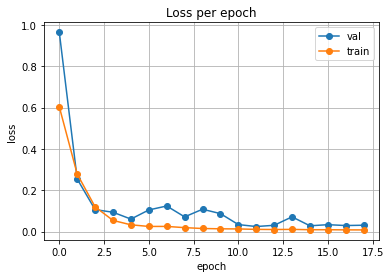

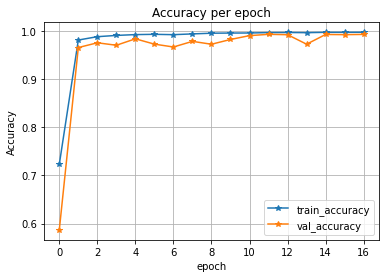

In [ ]:
plot_loss(history)
plot_acc(history)

filename = "/content/drive/Shareddrives/TPC Mini Project 2/All Methods Result/Method 4/modelunet-RIM-1" # no need extention

# Save Model
pickle.dump(model, open(filename, 'wb'))

# Import model
#model = pickle.load(open(filename, 'rb'))

#### Evaluation
---
Loading data untuk test kemudian evaluasi untuk data test tersebut. Citra hasil segmentasi dan skornya disimpan dalam dictionary. Waktu yang diperlukan dalam proses ini juga ditampilkan

In [ ]:
start_time = time.time()
t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = ImageTestDataset(images, DL_truths, test_keys, transform=t_test)

DL_imgs, DL_accs = predict_images(model, test_set, mean, std)
DL_perfs = {}

print('Performa Deep Learning UNet-MobileNetV2')
for key in test_set.keys:
    DL_perfs[key] = eval_perf(DL_truths[key], DL_imgs[key])
    print('Citra', key, ':', DL_perfs[key])

print('Total time for UNet-MobileNetV2 evaluation: {:.2f} m' .format((time.time()- start_time)/60))

Performa Deep Learning UNet-MobileNetV2
Citra G-27-R : {'ACC': 0.9967559759766282, 'SP': 0.9967924126532391, 'SN': 0.9957814807002742, 'PPV': 0.9206831225274419, 'FDR': 0.07931687747255808, 'DICE': 0.9567609038664756, 'OL': 0.9171060664927568}
Citra N-18-R : {'ACC': 0.9983643292932267, 'SP': 0.999076284450186, 'SN': 0.9783498936541697, 'PPV': 0.9741441982488858, 'FDR': 0.025855801751114203, 'DICE': 0.9762425163926637, 'OL': 0.9535876728859185}
Citra S-1-L : {'ACC': 0.9871258417861978, 'SP': 0.9951185275499508, 'SN': 0.8486997175416383, 'PPV': 0.9094097019286966, 'FDR': 0.09059029807130334, 'DICE': 0.8780065092752134, 'OL': 0.7825415356982488}
Citra G-31-R : {'ACC': 0.9908971260848817, 'SP': 0.9999321877585342, 'SN': 0.7489862615747745, 'PPV': 0.9975817177864656, 'FDR': 0.0024182822135343195, 'DICE': 0.8555922360302124, 'OL': 0.7476288286111279}
Citra S-13-R : {'ACC': 0.9977636660364858, 'SP': 0.9987266668472813, 'SN': 0.9776631087863151, 'PPV': 0.9735341732948547, 'FDR': 0.026465826705

#### Post Evaluation
---
Menyimpan skor ke Google Drive sebagai file Excel dan menampilkan summary dari skor tersebut

In [ ]:
DL_perfs_summary = save_scores_and_get_summary(DL_perfs, 'DL')

Scores of DL for 32 images:
      Accuracy  Precision  Sensitivity  Specificity       FDR      DICE   Overlap
mean  0.995277   0.960925     0.921142     0.998386  0.039075  0.934695  0.885151
std   0.004319   0.034377     0.119880     0.001527  0.034377  0.075496  0.109952


In [ ]:
## delete variable that will not be used to save memory
#del DL_truths, train_loader, val_loader, t_test, test_set
#del model, DL_imgs

## Comparison
---
Perbandingan dari berbagai skor yang telah didapatkan dari berbagai metode

#### Load Excel Files as DataFrame
---
Load file Excel yang berisi skor sebagai DataFrame. Berbagai DataFrame itu disatukan dalam satu dictionary dengan nama file sebagai key nya

In [ ]:
result_path = "/content/drive/Shareddrives/TPC Mini Project 2/All Methods Result/"
scores = {}

for file in os.listdir(result_path):
    if(file.endswith('.xlsx')):
        key = file.split('.')[0]
        scores[key] = pd.read_excel(result_path + file, usecols='B:H')

#### Calculate mean and std of each result
---
Menghitung mean dan standar deviasi dari tiap DataFrame untuk mendapatkan score summary nya

In [ ]:
DF_list = []
for key in scores.keys():
    score = scores[key]
    s_mean = score.mean(axis = 0)
    s_std = score.std(axis = 0)
    dic = {'mean': s_mean, 'std': s_std}
    DF_list.append(pd.DataFrame(dic).transpose())

#### Final Summary of Scores
---
Menggabungkan semua summary menjadi satu buah DataFrame kemudian menyimpan dan menampilkannya

In [ ]:
DF_summary = pd.concat(DF_list, axis=0, keys=summaries.keys())
DF_summary.to_excel("/content/drive/Shareddrives/TPC Mini Project 2/All Methods Result/" + "All Scores Summary.xlsx")

In [ ]:
DF_summary

ACC        SP        SN       PPV       FDR      DICE        OL
Scores_RF_2021-06-18-12-07-14                      mean  0.992625  0.993687  0.926997  0.888649  0.111351  0.886161  0.820047
                                                   std   0.023175  0.023806  0.075872  0.195231  0.195231  0.155632  0.178882
Scores_GC_2021-06-18-12-49-14                      mean  0.997129  0.997371  0.982502  0.872014  0.127986  0.919520  0.856637
                                                   std   0.002747  0.002923  0.018012  0.105601  0.105601  0.063684  0.096541
Scores_Thresh_2021-06-18-13-28-52                  mean  0.991203  0.991496  0.973223  0.862950  0.137050  0.894976  0.838193
                                                   std   0.029424  0.030019  0.038776  0.196962  0.196962  0.169776  0.187654
Scores_Thresh+ellipse_2021-06-18-13-28-52          mean  0.990040  0.990283  0.975195  0.849732  0.150268  0.886602  0.828739
                                                   std   0.032561  0.033134  0.039514  0.211444  0.211444  0.181563  0.203141
Scores_Grabcut_2021-06-18-13-28-52                 mean  0.988963  0.989156  0.978512  0.829229  0.170771  0.885351  0.811648
                                                   std   0.036230  0.036902  0.020422  0.190307  0.190307  0.176535  0.183850
Scores_Grabcut+ellipse_2021-06-18-13-28-52         mean  0.988897  0.988793  0.995723  0.829822  0.170178  0.886555  0.826513
                                                   std   0.037831  0.038456  0.010207  0.192896  0.192896  0.179182  0.191672
Scores_DL_2021-06-18-13-55-33                      mean  0.998168  0.999585  0.906749  0.972853  0.027147  0.932220  0.881066
                                                   std   0.001605  0.000727  0.118020  0.049817  0.049817  0.080166  0.112803
Scores_DL_2021-06-19-14-39-29                      mean  0.998436  0.999351  0.940030  0.958684  0.041316  0.947092  0.900848
                                                   std   0.000749  0.000841  0.048193  0.055744  0.055744  0.029505  0.050616
Scores_RF_2021-06-20-05-53-08                      mean  0.986332  0.996949  0.318246  0.814342  0.185658  0.410234  0.284547
                                                   std   0.010159  0.010561  0.214963  0.208887  0.208887  0.216197  0.198101
Scores_RF_2021-06-20-07-03-57                      mean  0.991893  0.992590  0.948631  0.865101  0.134899  0.883182  0.817493
                                                   std   0.025222  0.025835  0.065183  0.201681  0.201681  0.162976  0.187026
Scores_RF_2021-06-20-13-33-42 DRIONS - 20 for t... mean  0.979106  0.991913  0.605037  0.827810  0.172190  0.664746  0.495866
                                                   std   0.012151  0.014422  0.215220  0.189502  0.189502  0.158773  0.158021
Scores_RF_2021-06-20-13-37-22 DRIONS - 1 for train mean  0.953053  0.957777  0.819801  0.659643  0.340357  0.667710  0.509610
                                                   std   0.065059  0.070080  0.192112  0.309540  0.309540  0.217004  0.213056
Scores_Thresh_2021-06-20-13-37-56 DRIONS           mean  0.971582  0.999810  0.132209  0.979512  0.020488  0.218821  0.130844
                                                   std   0.004851  0.000718  0.105467  0.078613  0.078613  0.151304  0.103589
Scores_Thresh+ellipse_2021-06-20-13-37-56 DRIONS   mean  0.972219  0.999781  0.152753  0.980711  0.019289  0.248375  0.150767
                                                   std   0.004946  0.000824  0.113464  0.069683  0.069683  0.157570  0.110711
Scores_Thresh_2021-06-20-14-03-29 DRIONS           mean  0.971582  0.999810  0.132209  0.979512  0.020488  0.218821  0.130844
                                                   std   0.004851  0.000718  0.105467  0.078613  0.078613  0.151304  0.103589
Scores_Thresh+ellipse_2021-06-20-14-03-29 DRIONS   mean  0.972219  0.999781  0.152753  0.980711  0.019289  0.248375  0.150767
                              

Tabel di atas merupakan ringkasan dari sebagian pengujian yang telah kami lakukan. Nama-nama di kolom pertama adalah berdasarkan nama file Excel yang ada. Keterangan terkait penamaan file tersebut:
- Terdapat timestamp yang menunjukan kapan file itu dibuat. Timestamp yang ada adalah berdasarkan UTC, bukan berdasarkan local time
- Keterangan "DRIONS" menunjukan penggunaan Dataset 2 (DRIONS-DB), "RIM" menunjukan penggunaan Dataset 3 (RIM-ONE r3), dan jika tidak ada "DRIONS" atau pun "RIM" berarti menggunakan Dataset 1
- Keterangan "GC" berarti GrowCut, yaitu metode 1
- Keterangan "Thresh" berarti Threshold tanpa Grabcut, "Grabcut" berarti Threshold dengan Grabcut, "ellipse" berarti menggunakan Fit-Ellipse. Ketiganya merujuk pada metode 2
- Keterangan "RF" berarti Random Forest, yaitu metode 3. Terdapat pula keterangan berapa citra yang digunakan untuk training
- Keterangan "DL" berarti Deep Learning, yaitu metode 4

Secara umum, hasil pengujian untuk Dataset 1 pada tiap metode sudah cukup baik. Namun, hasilnya tidak terlalu baik ketika diujikan di dataset lainnya. Ini wajar saja karena kodenya memang awalnya ditujukan untuk Dataset 1 saja. Meski demikian, metode 4 yaitu Deep Learning masih memberikan hasil yang baik untuk dua dataset lainnya